# DenseNet Architecture

In [1]:
import os
import pathlib
import tensorflow as tf

from bcd.model.factory import DenseNetFactory
from bcd.model.transfer import X4Learner, fine_tune

In [2]:
batch_size = 32
input_shape = (224,224,3)
output_shape = 1

initial_epochs = 100  # Number of epochs to train for feature extraction

fine_tune_epochs = 10  # Number of epochs for each fine tune session
sessions = 10 # Number of fine tuning sessions to execute.
fine_tune_thaw_rate = 0.05  # Additional proportion of layers to unthaw each fine tune round. 

early_stop_monitor = "val_loss"  # Monitor validation loss for early stopping
early_stop_patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
early_stop_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.

learning_rate_base = 0.0001  # Base learning rate for the Adam optimizer 

loss = "binary_crossentropy"
activation = "sigmoid"
metric = "accuracy"

train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')
checkpoint_path = "models/checkpoints/densenet.ckpt"
model_directory = "models/densenet/"

## Preliminaries - Callbacks
Create a callback checkpoint that will automatically save model weights at each epoch.

In [3]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [4]:
# Create an early stopping callback that will stop training if validation loss doesn't improve in n epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, 
                                                       mode="auto",
                                                       verbose=True,
                                                       patience=early_stop_patience, 
                                                       restore_best_weights=early_stop_restore_best_weights)

## Load Data

In [5]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Model

In [6]:
factory = DenseNetFactory()
densenet = factory.create(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate_base, trainable=False, loss=loss, activation=activation, metric=metric)
densenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

## Feature Extraction

INFO:X4Learner:Starting feature extraction stage for densenet_feature_extraction.
Epoch 1/5
7/7 [==============================] - 54s 5s/step - loss: 0.8396 - accuracy: 0.4253 - val_loss: 0.8165 - val_accuracy: 0.3818
Epoch 2/5
7/7 [==============================] - 36s 5s/step - loss: 0.8263 - accuracy: 0.3982 - val_loss: 0.7552 - val_accuracy: 0.4364
Epoch 3/5
7/7 [==============================] - 38s 5s/step - loss: 0.7368 - accuracy: 0.5068 - val_loss: 0.7135 - val_accuracy: 0.4909
Epoch 4/5
7/7 [==============================] - 37s 5s/step - loss: 0.7708 - accuracy: 0.4570 - val_loss: 0.6966 - val_accuracy: 0.5455
Epoch 5/5
7/7 [==============================] - 38s 5s/step - loss: 0.7364 - accuracy: 0.5204 - val_loss: 0.6857 - val_accuracy: 0.6000
INFO:X4Learner:Best val_loss score for densenet_feature_extraction is 0.6857
INFO:X4Learner:Completed feature extraction stage for densenet_feature_extraction.


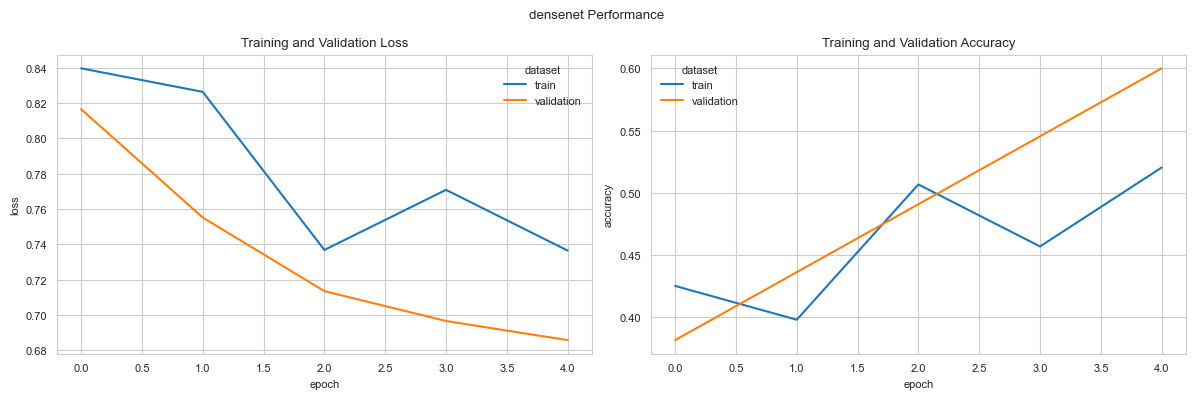

In [7]:
x4l = X4Learner(name="densenet", model=densenet, base_model_layer=5, train_ds=train_ds_10, val_ds=val_ds_10, 
                learning_rate=learning_rate_base, 
                patience=early_stop_patience,                
                callbacks=[early_stop_callback])
#x4l.extract_features(epochs=initial_epochs)
x4l.extract_features(epochs=5)

## Fine Tuning - Resume Strategy

In [8]:
fine_tune(model=densenet, base_model_layer=5, train_ds=train_ds_10, val_ds=val_ds_10, learning_rate=learning_rate_base, initial_epoch=5, callbacks=[early_stop_callback])


Epoch 6/15


ValueError: in user code:

    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 438, in update_state
        self.build(y_pred, y_true)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 358, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 484, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 484, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 503, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/metrics.py", line 4262, in get
        return deserialize(str(identifier))
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/metrics.py", line 4218, in deserialize
        return deserialize_keras_object(
    File "/home/john/anaconda3/envs/bcd/lib/python3.10/site-packages/keras/utils/generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: val_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
